In [7]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
import os
import sys
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Loading Data

In [8]:
data = pd.read_csv('data/cs-training.csv', index_col=0)
data.head()

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
1                 1                              0.766127   45   
2                 0                              0.957151   40   
3                 0                              0.658180   38   
4                 0                              0.233810   30   
5                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
1                                     2   0.802982         9120.0   
2                                     0   0.121876         2600.0   
3                                     1   0.085113         3042.0   
4                                     0   0.036050         3300.0   
5                                     1   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
1                               13                        0   
2                                4                        0   
3                                2                        1   
4                                5                        0   
5                                7                        0   

   NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
1                             6                                     0   
2                             0                                     0   
3                             0                                     0   
4                             0                                     0   
5                             1                                     0   

   NumberOfDependents  
1                 2.0  
2                 1.0  
3                 0.0  
4                 0.0  
5                 0.0

In [9]:
target_col = 'SeriousDlqin2yrs'

## Splitting into Training and Dev Sets

In [10]:
train = data.sample(n=120000, random_state=3)
dev = data[~data.index.isin(train.index)]
train[target_col].value_counts(normalize=True), dev[target_col].value_counts(normalize=True)

(0    0.933217
 1    0.066783
 Name: SeriousDlqin2yrs, dtype: float64, 0    0.932933
 1    0.067067
 Name: SeriousDlqin2yrs, dtype: float64)

## Cleaning Data

In [11]:
def clean_data(df, income_mv, dependent_mv):
    """
    Imputes missing values
    Floors & ceils the outliers
    Combines smaller categories into a single category
    """
    
    df.columns = [col.replace('-', '_') for col in df.columns]
    
    # RevolvingUtilizationOfUnsecuredLines
    df.loc[df['RevolvingUtilizationOfUnsecuredLines'] >1, 'RevolvingUtilizationOfUnsecuredLines'] = 1
    
    # age
    df.loc[df['age']< 21, 'age'] = 21
    
    # NumberOfTime30-59DaysPastDueNotWorse
    df.loc[df['NumberOfTime30_59DaysPastDueNotWorse']>=2, 'NumberOfTime30_59DaysPastDueNotWorse'] = 2
    
    # NumberOfTime60-89DaysPastDueNotWorse
    df.loc[df['NumberOfTime60_89DaysPastDueNotWorse']>=1, 'NumberOfTime60_89DaysPastDueNotWorse'] = 1
    
    # NumberOfTimes90DaysLate
    df.loc[df['NumberOfTimes90DaysLate']>=1, 'NumberOfTimes90DaysLate'] = 1
    
    # MonthlyIncome
    df['MonthlyIncome'] = df['MonthlyIncome'].fillna(income_mv) #replace with median
    
    # NumberOfOpenCreditLinesAndLoans

    # NumberRealEstateLoansOrLines
    df.loc[df['NumberRealEstateLoansOrLines']>=3, 'NumberRealEstateLoansOrLines'] = 3
    
    # NumberOfDependents
    df.loc[df['NumberOfDependents']>=3, 'NumberOfDependents'] = 3
    df['NumberOfDependents'] = df['NumberOfDependents'].fillna(dependent_mv) #replace with median
    
    return df



In [12]:
train = clean_data(train, 5400, 0)
dev = clean_data(dev, 5400, 0)

In [13]:
def get_bins_from_training_data(df):
    '''bin variables based on the eda done in the other notebook'''
    binsdf = {}
    _, binsdf['RevolvingUtilizationOfUnsecuredLines'] = pd.qcut(df['RevolvingUtilizationOfUnsecuredLines'], 5, retbins=True, labels=None)
    _, binsdf['DebtRatio'] = pd.qcut(df['DebtRatio'], 5, retbins=True, labels=None)
    _, binsdf['age'] = pd.qcut(df['age'], 5, retbins=True, labels=None)
    _, binsdf['MonthlyIncome'] = pd.qcut(df['MonthlyIncome'], 4, retbins=True, labels=None)
    _, binsdf['NumberOfOpenCreditLinesAndLoans'] = pd.qcut(df['NumberOfOpenCreditLinesAndLoans'], 5, retbins=True, labels=None)
    return binsdf

binsdf = get_bins_from_training_data(train)

In [21]:
def create_bins(df, binsdf):
    '''create bins on the unseen data set'''
    retdf = pd.DataFrame()
    for column in df.columns:
        if column in binsdf.keys():
            retdf[column] = pd.cut(df[column], bins=binsdf[column], labels=False, include_lowest=True)
        else:
            retdf[column] = df[column].copy(deep=True)
    return retdf

def create_bins_2(df, binsdf):
    '''create bins on the unseen data set'''
    retdf = pd.DataFrame()
    for column in df.columns:
        if column in binsdf.keys():
            retdf[column] = pd.cut(df[column], bins=binsdf[column], include_lowest=True)
        else:
            retdf[column] = df[column].copy(deep=True)
    return retdf

train_binned_df = create_bins(train, binsdf)
dev_binned_df = create_bins(dev, binsdf)

train_binned_df_2 = create_bins_2(train, binsdf)
dev_binned_df_2 = create_bins_2(dev, binsdf)

In [22]:
def weight_of_evidence(df, labelcol, col, categorical_col=None):
    '''calculates weight of evidence values for each category in a given variable (col)'''
    if categorical_col is None:
        categorical_col = col
    
    tempdf = df.groupby(by=categorical_col).agg({labelcol:{
                                                        '_counts': 'size',
                                                        '_bads': lambda x: len(x[x==1]),
                                                        '_goods': lambda x: len(x[x==0])
                                                    }})
    tempdf.columns  = [col+ column for column in tempdf.columns.droplevel(0)]
    tempdf[col+'_distri_tot'] = tempdf[col+'_counts']/(tempdf[col+'_counts'].sum())
    tempdf[col+'_distri_bads'] = tempdf[col+'_bads']/(tempdf[col+'_bads'].sum())
    tempdf[col+'_distri_goods'] = tempdf[col+'_goods']/(tempdf[col+'_goods'].sum())
    tempdf[col+'_bad_rate'] = tempdf[col+'_bads']/tempdf[col+'_counts']
    tempdf[col+'_woe'] = np.log(tempdf[col+'_distri_goods']) - np.log(tempdf[col+'_distri_bads'])
    return tempdf


def information_value(df, col):
    '''calculates Information Value using the Weight of evidence scores'''
    df['diff_col'] = df[col+'_distri_goods'] - df[col+'_distri_bads']
    return np.sum(df['diff_col']*df[col+'_woe'])


In [23]:
def get_woe_from_training_data(binned_df):
    '''calculates the wWeight of Evidence and Information Values based on the training data set for all the features'''
    woe_dict = {}
    iv_dict = {}
    for column in binned_df.columns:
        if column == target_col:
            pass
        else:
            woe_df = weight_of_evidence(binned_df, target_col, column)
            woe_column = [col for col in woe_df.columns if 'woe' in col][0]
            woe_dict[column] = dict(woe_df[woe_column])
            iv_dict[column] = information_value(woe_df, column)
    return woe_dict, iv_dict
 

woe, iv = get_woe_from_training_data(create_bins(train, binsdf))

In [24]:
iv = pd.DataFrame.from_dict(iv, orient='index')
iv.columns = ['information_value']
iv.sort_values(by='information_value', ascending=False)

information_value
RevolvingUtilizationOfUnsecuredLines           1.051496
NumberOfTimes90DaysLate                        0.822086
NumberOfTime30_59DaysPastDueNotWorse           0.736713
NumberOfTime60_89DaysPastDueNotWorse           0.562831
age                                            0.240657
MonthlyIncome                                  0.061015
NumberRealEstateLoansOrLines                   0.057126
DebtRatio                                      0.054804
NumberOfOpenCreditLinesAndLoans                0.048957
NumberOfDependents                             0.032749

In [25]:
def create_woe(binned_df, woe):
    '''Applies the calculated WoE values on the unseen data set'''
    for column in woe.keys():
        binned_df[column] = binned_df[column].map(woe[column])
    return binned_df


train_woe = create_woe(train_binned_df, woe)
dev_woe =  create_woe(dev_binned_df, woe)

In [26]:
train_woe.columns = [col.replace('-', '_') for col in train_woe.columns]
dev_woe.columns = [col.replace('-', '_') for col in dev_woe.columns]
train_woe.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30_59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60_89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

## Model

In [27]:
from sklearn.linear_model import LogisticRegression

In [111]:
var_cols = [
     'RevolvingUtilizationOfUnsecuredLines',
            'age',
       'NumberOfTime30_59DaysPastDueNotWorse',
            'DebtRatio', 
            'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans',
            'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines',
            'NumberOfTime60_89DaysPastDueNotWorse',
       'NumberOfDependents'
           ]
target_col = 'SeriousDlqin2yrs'

### Fitting the model

In [112]:
sk_model = LogisticRegression()
sk_model.fit(train_woe[var_cols], train_woe[target_col])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [113]:
sk_model.coef_

array([[-0.62874864, -0.45489465, -0.52473096, -0.6628081 , -0.26509248,
        -0.54912811, -0.40881292]])

In [114]:
#coefficients

coef = pd.DataFrame()
coef['feature'] = var_cols
coef['coef'] = sk_model.coef_[0]
coef

feature      coef
0  RevolvingUtilizationOfUnsecuredLines -0.628749
1                                   age -0.454895
2  NumberOfTime30_59DaysPastDueNotWorse -0.524731
3                             DebtRatio -0.662808
4                         MonthlyIncome -0.265092
5               NumberOfTimes90DaysLate -0.549128
6  NumberOfTime60_89DaysPastDueNotWorse -0.408813

We remove the NumberOfOpenCreditLinesAndLoans as it is not significant by p-value (0.9) and make the model again

In [115]:
# saving model
# sk_model.save('model_sk_10_variables_1.pkl')

### Checking performance

-----   Training Set Performance   --------

ROC_AUC:  0.8524552185078965
Somersd:  0.704910437015793


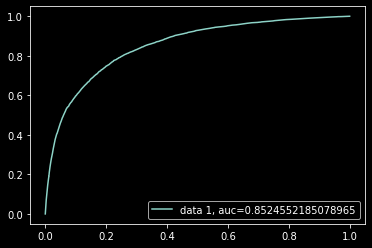

In [116]:
import sklearn.metrics as setrics
plt.style.use('dark_background')

def get_metrics(df, model, var_cols, label_col):
    '''plots roc-auc and calcualtes somers-d score'''
    roc_auc = setrics.roc_auc_score(df[label_col],  model.predict_proba(df[var_cols])[:,1])
    print('ROC_AUC: ', roc_auc)
    
    somersd = 2*roc_auc -1
    print('Somersd: ', somersd)
    
    fpr, tpr, _ = setrics.roc_curve(df[label_col],  model.predict_proba(df[var_cols])[:,1])
    plt.plot(fpr,tpr,label="data 1, auc="+str(roc_auc))
    plt.legend(loc=4)
    plt.show()

print('-----   Training Set Performance   --------\n')    
get_metrics(train_woe, sk_model, var_cols, label_col='SeriousDlqin2yrs')

-----   Dev Set Performance   --------

ROC_AUC:  0.8604793024174683
Somersd:  0.7209586048349366


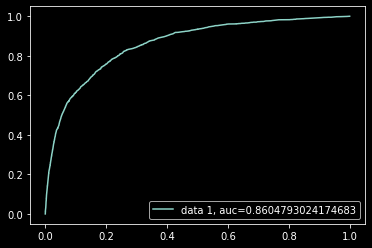

In [117]:
print('-----   Dev Set Performance   --------\n')    

get_metrics(dev_woe.dropna(), sk_model, var_cols, label_col='SeriousDlqin2yrs')

## Scorecard

### Calculating Offset

Let's set the odds of 50:1 at a score of 600

In [47]:
score= 600
odds = 50
pdo = 20
factor = pdo/np.log(2)

offset = score - np.log(odds)*factor
offset

487.1228762045055

In [52]:
def make_scorecard(woe_df, model, features, pdo=20, offset_score=600):
    '''calculates credit score'''
    factor = pdo/np.log(2)
    n = len(features)
    offset = offset_score - np.log(50)*factor
    
    scorecard = -(((woe_df[features]*(model.coef_)).sum(axis=1)) + model.intercept_)*factor +  offset
    return scorecard

In [53]:
train_scorecard = make_scorecard(train_woe, sk_model, var_cols, offset_score=600)
dev_scorecard = make_scorecard(dev_woe, sk_model, var_cols, offset_score=600)

In [54]:
train['credit_score'] = train_scorecard
train.to_csv('output/train_credit_scores.csv')

dev['credit_score'] = dev_scorecard
dev.to_csv('output/dev_credit_scores.csv')

## Predicting on Test Data

In [118]:
test = pd.read_csv('data/cs-test.csv', index_col=0)
test.head()

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
1               NaN                              0.885519   43   
2               NaN                              0.463295   57   
3               NaN                              0.043275   59   
4               NaN                              0.280308   38   
5               NaN                              1.000000   27   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
1                                     0   0.177513         5700.0   
2                                     0   0.527237         9141.0   
3                                     0   0.687648         5083.0   
4                                     1   0.925961         3200.0   
5                                     0   0.019917         3865.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
1                                4                        0   
2                               15                        0   
3                               12                        0   
4                                7                        0   
5                                4                        0   

   NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
1                             0                                     0   
2                             4                                     0   
3                             1                                     0   
4                             2                                     0   
5                             0                                     0   

   NumberOfDependents  
1                 0.0  
2                 2.0  
3                 2.0  
4                 0.0  
5                 1.0

In [119]:
test = clean_data(test, 5400, 3)
test_binned_df = create_bins(test, binsdf)
test_woe = create_woe(test_binned_df, woe)
test_scorecard = make_scorecard(test_woe, sk_model, var_cols)
test_scorecard.describe()

count    101503.000000
mean        582.354438
std          33.904528
min         433.702004
25%         563.905825
50%         592.109510
75%         606.839813
max         625.913696
dtype: float64

In [120]:
test['credit_score'] = test_scorecard
test.to_csv('output/test_credit_scores.csv')

### Score distribution

In [121]:
dev['credit_score'] = dev_scorecard

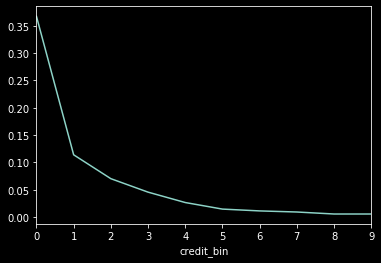

In [122]:
plt.style.use('dark_background')
dev['credit_bin'] = pd.qcut(dev['credit_score'], 10, labels=False)
dev['credit_bin_range'] = pd.qcut(dev['credit_score'], 10)
dev.groupby(by='credit_bin').agg('mean')[target_col].plot()

In [123]:
score_bins = dev.groupby(by='credit_bin_range').agg('mean')[target_col].reset_index()
score_bins.columns =['credit_bin', 'default_rate']
score_bins['default_rate'] = score_bins['default_rate'].round(3).mul(100)
score_bins

credit_bin  default_rate
0  (430.72700000000003, 538.407]          36.7
1             (538.407, 557.485]          11.4
2             (557.485, 571.319]           7.0
3             (571.319, 583.019]           4.6
4             (583.019, 591.464]           2.7
5             (591.464, 598.953]           1.5
6             (598.953, 605.154]           1.1
7             (605.154, 610.533]           0.9
8             (610.533, 616.912]           0.6
9             (616.912, 628.477]           0.6

In [124]:
score_bins['min_score'] = score_bins['credit_bin'].apply(lambda x: int(x.left))
score_bins['max_score'] = score_bins['credit_bin'].apply(lambda x: int(x.right))
score_bins = score_bins.reset_index()
score_bins.columns = ['decile', 'credit_bin', 'default_rate', 'min_score', 'max_score']
score_bins = score_bins[['decile', 'credit_bin', 'min_score', 'max_score', 'default_rate']]
score_bins['decile'] = score_bins['decile'] + 1
score_bins

decile                     credit_bin min_score max_score  default_rate
0       1  (430.72700000000003, 538.407]       430       538          36.7
1       2             (538.407, 557.485]       538       557          11.4
2       3             (557.485, 571.319]       557       571           7.0
3       4             (571.319, 583.019]       571       583           4.6
4       5             (583.019, 591.464]       583       591           2.7
5       6             (591.464, 598.953]       591       598           1.5
6       7             (598.953, 605.154]       598       605           1.1
7       8             (605.154, 610.533]       605       610           0.9
8       9             (610.533, 616.912]       610       616           0.6
9      10             (616.912, 628.477]       616       628           0.6

In [125]:
dev_binned_df_3 = dev_binned_df_2.join(dev_woe, rsuffix='_woe')
dev_binned_df_3.head()

SeriousDlqin2yrs RevolvingUtilizationOfUnsecuredLines             age  \
7                  0                        (0.27, 0.697]    (56.0, 65.0]   
9                  0                       (0.0828, 0.27]  (20.999, 39.0]   
13                 0                     (-0.001, 0.0191]    (39.0, 48.0]   
20                 0                        (0.27, 0.697]  (20.999, 39.0]   
25                 0                     (0.0191, 0.0828]    (56.0, 65.0]   

    NumberOfTime30_59DaysPastDueNotWorse         DebtRatio  \
7                                      0  (3.62, 329664.0]   
9                                      0  (3.62, 329664.0]   
13                                     0    (0.287, 0.468]   
20                                     0   (-0.001, 0.134]   
25                                     0    (0.134, 0.287]   

           MonthlyIncome NumberOfOpenCreditLinesAndLoans  \
7       (3900.0, 5400.0]                      (6.0, 9.0]   
9       (3900.0, 5400.0]                   (-0.001, 4.0]   
13  (7373.25, 1794060.0]                    (12.0, 57.0]   
20      (-0.001, 3900.0]                   (-0.001, 4.0]   
25      (-0.001, 3900.0]                      (6.0, 9.0]   

    NumberOfTimes90DaysLate  NumberRealEstateLoansOrLines  \
7                         0                             3   
9                         0                             0   
13                        0                             2   
20                        0                             0   
25                        0                             1   

    NumberOfTime60_89DaysPastDueNotWorse  ...  \
7                                      0  ...   
9                                      0  ...   
13                                     0  ...   
20                                     0  ...   
25                                     0  ...   

    RevolvingUtilizationOfUnsecuredLines_woe   age_woe  \
7                                  -0.041499  0.412348   
9                                   0.856237 -0.491161   
13                                  1.300265 -0.238303   
20                                 -0.041499 -0.491161   
25                                  1.407820  0.412348   

    NumberOfTime30_59DaysPastDueNotWorse_woe  DebtRatio_woe  \
7                                   0.538239       0.198680   
9                                   0.538239       0.198680   
13                                  0.538239       0.073002   
20                                  0.538239       0.093126   
25                                  0.538239       0.158030   

    MonthlyIncome_woe  NumberOfOpenCreditLinesAndLoans_woe  \
7            0.017534                             0.230913   
9            0.017534                            -0.351146   
13           0.368569                             0.001339   
20          -0.328794                            -0.351146   
25          -0.328794                             0.230913   

    NumberOfTimes90DaysLate_woe  NumberRealEstateLoansOrLines_woe  \
7                      0.384389                         -0.235988   
9                      0.384389                         -0.243963   
13                     0.384389                          0.206687   
20                     0.384389                         -0.243963   
25                     0.384389                          0.253011   

    NumberOfTime60_89DaysPastDueNotWorse_woe  NumberOfDependents_woe  
7                                   0.285051                0.145361  
9                                   0.285051                0.145361  
13                                  0.285051               -0.191095  
20                                  0.285051                0.145361  
25                                  0.285051                0.145361  

[5 rows x 22 columns]

In [127]:
score_list = []
dev_binned_df_3 = dev_binned_df_3.dropna()
for i, variable in enumerate(var_cols):
    for val in dev_binned_df_3[variable+'_woe'].unique():
#         try:
        temp_list = []
        temp_list.append(variable)
        _bin = dev_binned_df_3[dev_binned_df_3[variable+'_woe']==val][variable].mode().values[0]
#             if isinstance(_bin, Interval):
#                 _bin = (_bin.left, _bin.right)
        temp_list.append(_bin)
        temp_list.append((-val*sk_model.coef_[0][i] +\
                                     sk_model.intercept_/len(var_cols))*20/np.log(2) + \
                                    offset/len(var_cols))
        score_list.append(pd.Series(temp_list))
#         except:
#             pass
      

In [128]:
score_df = pd.concat(score_list, axis=1).T
score_df.columns = ['variable', 'bin', 'score']
score_df['left'] = score_df['bin'].apply(lambda x:x if (isinstance(x, np.int64) or isinstance(x, np.float64)) else x.left)
some_df = score_df.sort_values(by=['variable', 'left'], ascending=True).drop(columns=['left'])
# some_df.to_csv('tt.csv')
some_df['score'] = some_df['score'].apply(lambda x: x[0].round(1))
some_df

variable                   bin  score
15                             DebtRatio       (-0.001, 0.134]   60.6
16                             DebtRatio        (0.134, 0.287]   61.9
14                             DebtRatio        (0.287, 0.468]   60.2
17                             DebtRatio         (0.468, 3.62]   51.0
13                             DebtRatio      (3.62, 329664.0]   62.6
20                         MonthlyIncome      (-0.001, 3900.0]   56.3
18                         MonthlyIncome      (3900.0, 5400.0]   59.0
21                         MonthlyIncome     (5400.0, 7373.25]   59.4
19                         MonthlyIncome  (7373.25, 1794060.0]   61.6
10  NumberOfTime30_59DaysPastDueNotWorse                     0   67.0
11  NumberOfTime30_59DaysPastDueNotWorse                     1   45.3
12  NumberOfTime30_59DaysPastDueNotWorse                     2   30.0
24  NumberOfTime60_89DaysPastDueNotWorse                     0   62.2
25  NumberOfTime60_89DaysPastDueNotWorse                     1   34.5
22               NumberOfTimes90DaysLate                     0   64.9
23               NumberOfTimes90DaysLate                     1   22.6
2   RevolvingUtilizationOfUnsecuredLines      (-0.001, 0.0191]   82.4
3   RevolvingUtilizationOfUnsecuredLines      (0.0191, 0.0828]   84.4
1   RevolvingUtilizationOfUnsecuredLines        (0.0828, 0.27]   74.4
0   RevolvingUtilizationOfUnsecuredLines         (0.27, 0.697]   58.1
4   RevolvingUtilizationOfUnsecuredLines          (0.697, 1.0]   36.3
6                                    age        (20.999, 39.0]   52.4
7                                    age          (39.0, 48.0]   55.7
9                                    age          (48.0, 56.0]   57.9
5                                    age          (56.0, 65.0]   64.2
8                                    age         (65.0, 109.0]   72.5